In [25]:
import sqlite3 # SQLite に接続するためのライブラリ
import numpy as np # 今回は明示的には使わない
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb # LightGBM でモデルを作成する
from sklearn.metrics import accuracy_score, roc_auc_score #精度評価に使用

In [26]:
# 自作モジュールの読み込み
import sys
sys.path.append("../input/modeling-and-evaluation")
import ROC_AUC as my_ROC_AUC

In [27]:
# 学習データの読み込み
train_df =  pd.read_csv("../input/tdse-inclass-competition-0/train.csv")

# sqlite3 でデータベースに接続する
conn: sqlite3.Connection = sqlite3.connect("train.db")

# 学習データをデータベースに書き込む
train_df.to_sql(
    name="train",
    con=conn,
    if_exists="replace",
    index=False,
)

# Exited が 1 のデータを取得する
exited_1_df: pd.DataFrame = pd.read_sql_query("SELECT * FROM train WHERE Exited = 1", conn)

len_exited_1_df = len(exited_1_df)

# Exited が 0 のデータを、1のデータと同数取得する
exited_0_df: pd.DataFrame = pd.read_sql_query(f"SELECT * FROM train WHERE Exited = 0 LIMIT {len_exited_1_df}", conn)

# exited=1のデータと0のデータを結合する
train_equal_df = pd.concat([exited_1_df, exited_0_df])

In [28]:
# すべて0の列を追加
train_equal_df["all_0"] = 0

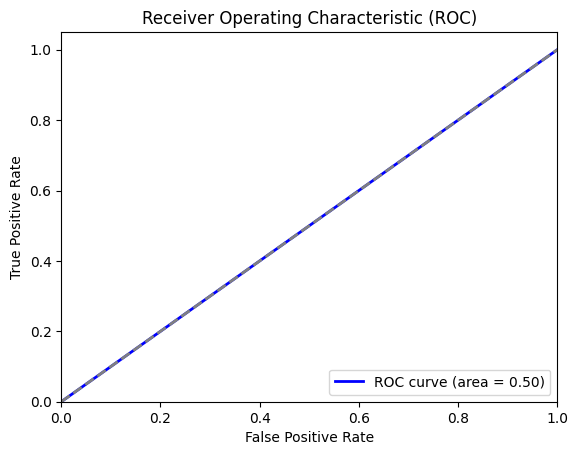

0.5

In [29]:
# roc曲線を描く
my_ROC_AUC.plot_roc_and_calculate_auc(
    actuals_df=train_equal_df,
    predictions_df=train_equal_df,
    actuals_column="Exited",
    predictions_column="all_0",
)

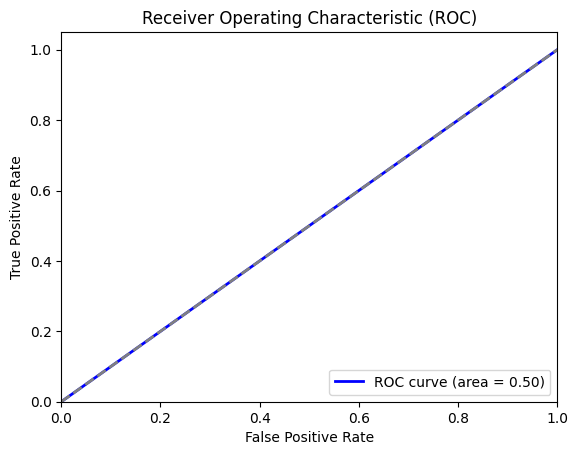

0.5

In [31]:
# train_df に対しても同様に行う
train_df["all_0"] = 1

# roc曲線を描く
my_ROC_AUC.plot_roc_and_calculate_auc(
    actuals_df=train_df,
    predictions_df=train_df,
    actuals_column="Exited",
    predictions_column="all_0",
)

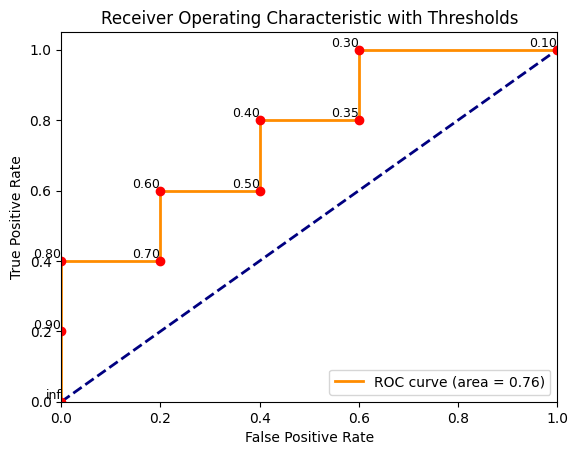

In [32]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve_with_thresholds(
    df: pd.DataFrame,
    true_label_col: str,
    predicted_prob_col: str,
) -> None:
    """
    ROC曲線をしきい値付きでプロットする関数

    Args:
        df (pd.DataFrame): データフレーム
        true_label_col (str): 正解ラベルのカラム名
        predicted_prob_col (str): 予測確率のカラム名
    """
    # 正解ラベルと予測確率を抽出
    true_labels = df[true_label_col]
    predicted_probs = df[predicted_prob_col]

    # fpr, tpr, threshold を計算
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

    # ROC AUC を計算
    roc_auc = auc(fpr, tpr)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label=f"ROC curve (area = {roc_auc:.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic with Thresholds")
    plt.legend(loc="lower right")

    # しきい値をプロット
    thresholds_length = len(thresholds)
    # 10個ごとにしきい値を表示
    for i in range(0, thresholds_length, max(1, thresholds_length // 10)):
        plt.plot(fpr[i], tpr[i], 'ro')
        plt.text(fpr[i], tpr[i], f'{thresholds[i]:.2f}', fontsize=9, va='bottom', ha='right')

    plt.show()

# 使用例
# dfはpandas.DataFrame、正解ラベルのカラム名は"正解"、予測確率のカラム名は"予測確率"と仮定
# サンプルデータの作成
data = {
    '正解': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    '予測確率': [0.1, 0.4, 0.35, 0.8, 0.5, 0.6, 0.2, 0.9, 0.7, 0.3]
}
df = pd.DataFrame(data)

plot_roc_curve_with_thresholds(
    df=df,
    true_label_col="正解",
    predicted_prob_col="予測確率",
)
